# pix2pix 모델을 이용한 도로 이미지 생성 예제

#### 초록
***
<span style="font-size:11pt; line-height:1.8;">
    &nbsp; &nbsp; 도로 이미지를 이용하여 pix2pix 모델을 학습하고 모델이 생성하는 이미지를 확인하는 예제를 진행하였다. pix2pix의 특징은, conditional GAN에 해당하여 특정 정보에 따라 생성 이미지를 달리할 수 있다는 것, 그리고 생성자 모델의 경우 U-Net을 이용하여 인코딩 단계의 정보를 디코더에 전달한 다는 것, 판별자 모델의 경우 출력의 형태를 행렬로 하여, 생성 이미지의 특정 부분에 대한 진위 여부를 출력한다는 것을 들 수 있다. 학습 데이터는 총 1,000장, 검증 데이터는 총 4장으로 도로 이미지 이다. 또한, 세로 256, 가로 512 크기의 3채널 컬러 이미지에 해당한다. 데이터 전처리 과정에서 이미지 회전을 통해 이미지 보강을 실시하였다. 모델은 총 500회 학습하였다. 최종 모델에 대한 손실값은 'Generator Loss'가 1.711, 'Discriminator Loss'가 0.446, 'L1 Loss'가 0.142 이다. 검증 데이터에 대한 모델의 생성 이미지를 확인한 결과 실제 도로와 흡사한 이미지를 생성하였다. 특히 차선의 형태를 생성할 수 있었으며, 학습 데이터의 특성에 따라 우측 통행 기준으로 차선을 생성한 것을 확인할 수 있었다.
</span>

***

<br>

## 1. 서론
***
<span style="font-size:12pt; line-height:1.7; font-family:Serif;">
    &nbsp; &nbsp; 본 예제는 Conditional GAN을 이용하여 세그먼테이션된 이미지를 입력하였을 때, 이를 실제 이미지와 비슷하게 만들고자 합니다. 따라서, pix2pix 모델을 생성, 학습 하고 최종적으로 모델이 출력한 이미지를 확인합니다. 기존 GAN의 경우 이미지를 무작위로 생성합니다. cGAN은 특정 정보를 입력함으로써 이에 해당하는 이미지를 생성하게 됩니다. [그림 1]은 예제의 이미지 데이터를 적용한 pix2pix의 구조를 제시한 것입니다. 예제에서는 도로의 객체가 픽셀별 다른 색으로 분리된 이미지를 넣어주면, 이를토대로 실제 이미지와 비슷하도록 이미지를 출력하는 것을 목표로 합니다. 다음은 본 예제의 진행 순서를 제시한 것입니다.
</span><br><br>


> _1. 데이터 분석_
>
> _2. 데이터 전처리_
>
> _3. 모델 생성_
>
> _4. 모델 학습 및 평가_

<img src="./img/cgan.png" width=700>

[그림 1] 예제를 적용한 Conditional Gan의 구조

***

<br>

## 2. 데이터 분석
***
<span style="font-size:12pt; line-height:1.7; font-family:Serif;">
    &nbsp; &nbsp; 이용하는 데이터는 도로 이미지로 세로 256, 가로 512 크기의 3채널 컬러 입니다. 학습 데이터 1,000장, 검증 데이터 4장입니다.
특이하게 실제 도로 이미지와 세그먼트된 이미지가 하나의 이미지로 붙어 있습니다. &lt;Fig. 2>를 통해 이를 확인할 수 있습니다.
</span>

***

#### 필요 라이브러리 호출
***
+ 예제에 사용할 라이브러리를 호출 합니다.
***

In [1]:
import os   #디렉토리 관리


import cv2   #이미지 처리
import imageio   #gif 저장
import numpy as np   #행렬 연산
import matplotlib.pyplot as plt   #데이터 시각화


import tensorflow as tf   #신경망
from tensorflow import data   #데이터
from tensorflow import image   #이미지 처리
import tensorflow_datasets as tfds   #데이터셋
from tensorflow.keras import losses   #손실값
from tensorflow.keras import optimizers   #옵티마이저
from tensorflow.keras import layers, Input, Model   #레이어
from tensorflow.keras.preprocessing.image import random_rotation   #이미지 보강

<br>

#### 데이터셋 불러오기
***
+ 예제에 사용할 이미지 데이터셋을 불러옵니다.


+ 학습 데이터 1,000장, 검증 데이터 4장임을 확인할 수 있습니다.
***

In [2]:
train_data_path = "./dataset/cityscapes/train/"
val_data_path = "./dataset/cityscapes/val/"
print("number of train examples :", len(os.listdir(train_data_path)))
print("number of train examples :", len(os.listdir(val_data_path)))

number of train examples : 1000
number of train examples : 4


<br>

#### 데이터셋 이미지 크기 확인
***
+ 세로 256, 가로 512 크기의 3채널 컬러 이미지임을 확인할 수 있습니다.
***

In [3]:
f = train_data_path + os.listdir(train_data_path)[0]
img = cv2.imread(f, cv2.IMREAD_COLOR)
print(img.shape)

(256, 512, 3)


<br>

#### 데이터셋 샘플 출력하기
***
+ 불러온 데이터셋의 일부를 출력 합니다.


+ 실제 도로 이미지와 세그멘트된 이미지가 함께 붙어있는 것을 확인할 수 있습니다.
***

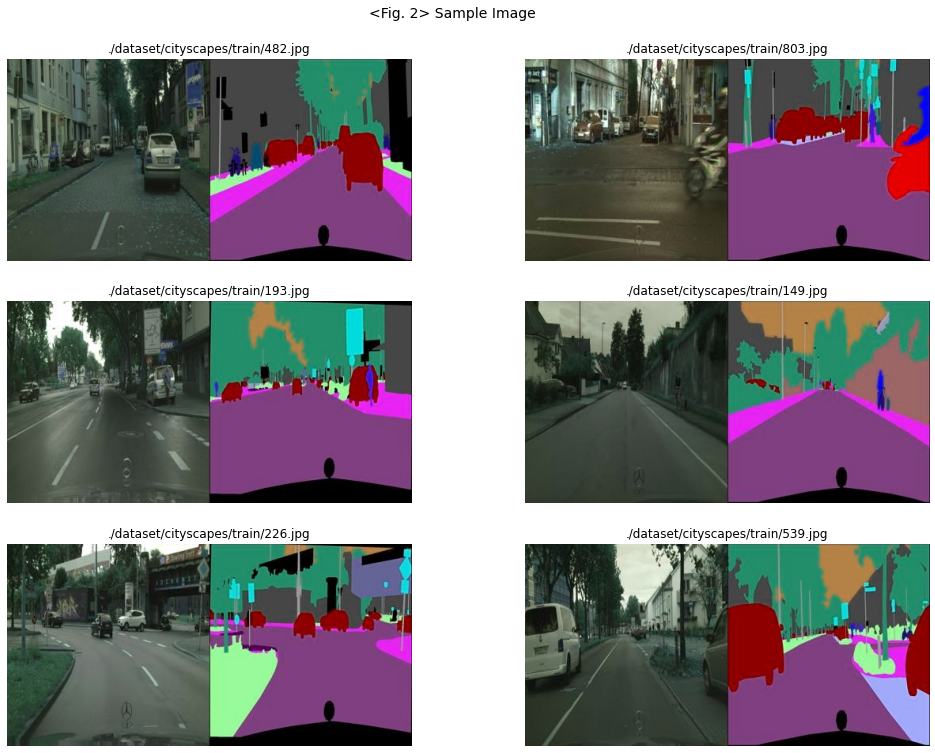

In [4]:
plt.figure(figsize=(17, 12))
plt.suptitle("<Fig. 2> Sample Image", size=14)
plt.subplots_adjust(top=0.92)
for i in range(1, 7):
    f = train_data_path + os.listdir(train_data_path)[np.random.randint(1000)]
    img = cv2.imread(f, cv2.IMREAD_COLOR)
    plt.subplot(3, 2, i)
    plt.title(f"{f}")
    plt.axis("off")
    plt.imshow(img)
plt.show()

<br>

## 3. 데이터 전처리
***
<span style="font-size:12pt; line-height:1.7; font-family:Serif;">
    &nbsp; &nbsp; 앞서 데이터를 분석을 통해 도로 이미지와 세그먼트된 이미지가 붙어 있는 것을 확인하였습니다. 따라서 이를 분할할 필요가 있습니다. 또한, 이미지를 보강하기 위해 이미지 회전을 시행하여 줍니다. &lt;Fig. 4>는 이미지 보강 예시를 제시한 것입니다.


</span>

***

#### 세그먼트 & 실제 이미지 분할 함수 생성
***
+ 하나의 이미지로 붙어있는 세그먼트와 실제 이미지를 분할하는 함수를 생성 합니다.
***

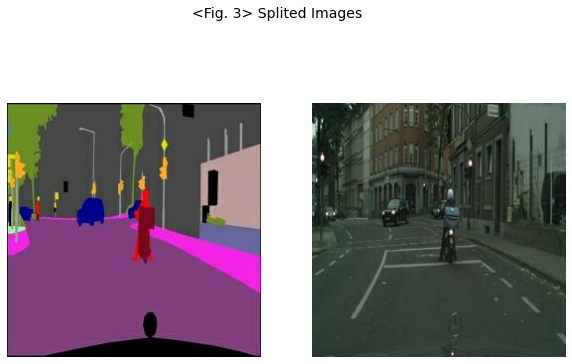

In [5]:
def normalize(x):
    x = tf.cast(x, tf.float32)
    return (x/127.5) - 1

def denormalize(x):
    x = (x+1)*127.5
    x = x.numpy()
    return x.astype(np.uint8)

def load_img(img_path):
    img = tf.io.read_file(img_path)
    img = tf.image.decode_image(img, 3)
    
    w = tf.shape(img)[1] // 2
    sketch = img[:, :w, :] 
    sketch = tf.cast(sketch, tf.float32)
    colored = img[:, w:, :] 
    colored = tf.cast(colored, tf.float32)
    return normalize(colored), normalize(sketch)


f = train_data_path + os.listdir(train_data_path)[1]
sketch, colored = load_img(f)

plt.figure(figsize=(10,7))
plt.suptitle("<Fig. 3> Splited Images", size=14)
plt.subplots_adjust(top=0.95)

plt.subplot(1,2,1)
plt.axis("off")
plt.imshow(denormalize(sketch))

plt.subplot(1,2,2)
plt.axis("off")
plt.imshow(denormalize(colored))
plt.show()

<br>

#### 이미지 보강 함수 생성
***
+ 이미지를 회전하여 보강하는 함수를 생성합니다.
***

In [6]:
@tf.function() # 빠른 텐서플로 연산을 위해 @tf.function()을 사용합니다. 
def apply_augmentation(sketch, colored):
    stacked = tf.concat([sketch, colored], axis=-1)
    
    _pad = tf.constant([[30,30],[30,30],[0,0]])
    if tf.random.uniform(()) < .5:
        padded = tf.pad(stacked, _pad, "REFLECT")
    else:
        padded = tf.pad(stacked, _pad, "CONSTANT", constant_values=1.)

    out = image.random_crop(padded, size=[256, 256, 6])
    
    out = image.random_flip_left_right(out)
    out = image.random_flip_up_down(out)
    
    if tf.random.uniform(()) < .5:
        degree = tf.random.uniform([], minval=1, maxval=4, dtype=tf.int32)
        out = image.rot90(out, k=degree)
    
    return out[...,:3], out[...,3:]   

<br>

#### 이미지 보강 예시 출력
***
+ 이미지 회전에 대한 예시를 출력합니다.
***

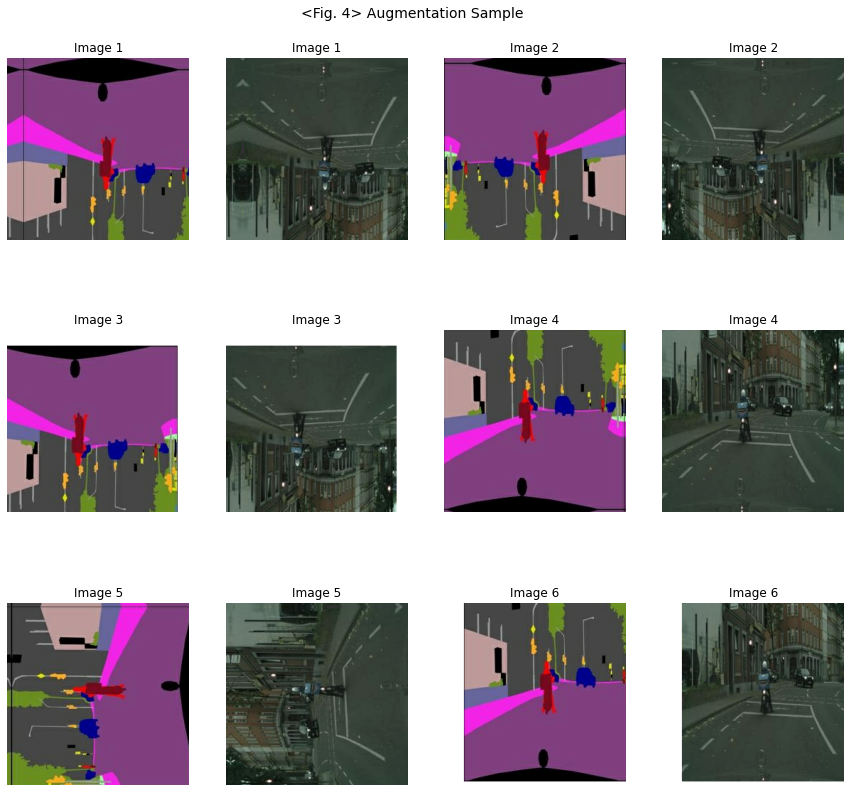

In [7]:
plt.figure(figsize=(15,13))
plt.suptitle("<Fig. 4> Augmentation Sample", size=14)
plt.subplots_adjust(top=0.95)

img_n = 1
for i in range(1, 13, 2):
    augmented_sketch, augmented_colored = apply_augmentation(sketch, colored)
    
    plt.subplot(3,4,i)
    plt.axis("off")
    plt.imshow(denormalize(augmented_sketch)); plt.title(f"Image {img_n}")
    plt.subplot(3,4,i+1)
    plt.axis("off")
    plt.imshow(denormalize(augmented_colored)); plt.title(f"Image {img_n}")
    img_n += 1
plt.show()

<br>

#### 데이터셋 생성
***
+ 전처리 과정을 거친 데이터를 이용하여 최종적으로 데이터셋을 생성합니다.
***

In [8]:
def get_train(img_path):
    sketch, colored = load_img(img_path)
    sketch, colored = apply_augmentation(sketch, colored)
    return sketch, colored

train_images = data.Dataset.list_files(train_data_path + "*.jpg")
train_images = train_images.map(get_train).shuffle(1000).batch(4)

sample = train_images.take(1)
sample = list(sample.as_numpy_iterator())
sketch, colored = (sample[0][0]+1)*127.5, (sample[0][1]+1)*127.5

<br>

## 4. 모델 생성 및 학습
***
<span style="font-size:12pt; line-height:1.7; font-family:Serif;">
    &nbsp; &nbsp; pix2pix 모델을 생성 및 학습을 진행합니다. pix2pix 모델의 생성자는 U-Net을 사용합니다. U-Net은 인코더의 정보를 같은 층의 디코더 레이어에 넘겨줌으로써 복원 시 해당 정보를 이용하여 복원합니다. 또한, pix2pix 모델의 판별자는 기존의 GAN과 다르게 하나의 값을 출력하지 않고 행렬 형태로 출력하는데, 이는 입력되는 이미지의 특정 영역에 대한 진위 여부를 원소로 하여 출력하는 것입니다. 학습의 경우 학습 회수를 500epoch로 설정하여 학습을 진행합니다.
</span>

***

#### 인코더 및 디코더 레이어 정의
***
+ 인코더 및 디코더에 사용할 블록 레이어를 정의한다.
***

In [9]:
class EncodeBlock(layers.Layer):
    def __init__(self, n_filters, use_bn=True):
        super(EncodeBlock, self).__init__()
        self.use_bn = use_bn       
        self.conv = layers.Conv2D(n_filters, 4, 2, "same", use_bias=False)
        self.batchnorm = layers.BatchNormalization()
        self.lrelu = layers.LeakyReLU(0.2)

    def call(self, x):
        x = self.conv(x)
        if self.use_bn:
            x = self.batchnorm(x)
        return self.lrelu(x)

    
class DecodeBlock(layers.Layer):
    def __init__(self, f, dropout=True):
        super(DecodeBlock, self).__init__()
        self.dropout = dropout
        self.Transconv = layers.Conv2DTranspose(f, 4, 2, "same", use_bias=False)
        self.batchnorm = layers.BatchNormalization()
        self.relu = layers.ReLU()
        
    def call(self, x):
        x = self.Transconv(x)
        x = self.batchnorm(x)
        if self.dropout:
            x = layers.Dropout(.5)(x)
        return self.relu(x)
    
    
class DiscBlock(layers.Layer):
    def __init__(self, n_filters, stride=2, custom_pad=False, use_bn=True, act=True):
        super(DiscBlock, self).__init__()
        self.custom_pad = custom_pad
        self.use_bn = use_bn
        self.act = act
        
        if custom_pad:
            self.padding = layers.ZeroPadding2D()
            self.conv = layers.Conv2D(n_filters, 4, stride, "valid", use_bias=False)
        else:
            self.conv = layers.Conv2D(n_filters, 4, stride, "same", use_bias=False)
        
        self.batchnorm = layers.BatchNormalization() if use_bn else None
        self.lrelu = layers.LeakyReLU(0.2) if act else None
        
    def call(self, x):
        if self.custom_pad:
            x = self.padding(x)
            x = self.conv(x)
        else:
            x = self.conv(x)
                
        if self.use_bn:
            x = self.batchnorm(x)
            
        if self.act:
            x = self.lrelu(x)
        return x

<br>

### 4.1. 생성자(Generator) 생성
***
<span style="font-size:12pt; line-height:1.7; font-family:Serif;">
    &nbsp; &nbsp; 예제에서 생성자의 모델로 U-Net을 이용합니다. U-Net은 디코딩 시에 인코딩 정보를 사용하여 이미지 특징을 추출 한는 것이 가장 큰 특징입니다. 기존의 오토인코더의 경우 저차원의 정보만을 이용하여 정보를 복원하였지만, U-Net의 경우 같은 단계에 있는 인코딩 층의 정보를 함께 이용하여 정보를 복원합니다. [그림 2]는 U-Net의 구조를 제시한 것으로 중심을 기준으로 인코더와 디코더가 U자 모양을 이루는 것을 확인할 수 있습니다[1]. 또한, 인코더 레이어에서 같은 층의 디코더 레이어로 정보가 전달 되는 것을 확인할 수 있습니다.
</span><br><br>

<img src="./img/Unet.jpg" width=600>

[그림 5] U-Net의 구조, https://arxiv.org/pdf/1505.04597.pdf
***

#### U-net 생성자 정의 및 생성
***
+ U-net 생성자의 정의 및 생성을 진행합니다.
***

In [10]:
#U-Net Generator 정의

class UNetGenerator(Model):
    def __init__(self):
        super(UNetGenerator, self).__init__()
        encode_filters = [64,128,256,512,512,512,512,512]
        decode_filters = [512,512,512,512,256,128,64]
        
        self.encode_blocks = []
        for i, f in enumerate(encode_filters):
            if i == 0:
                self.encode_blocks.append(EncodeBlock(f, use_bn=False))
            else:
                self.encode_blocks.append(EncodeBlock(f))
        
        self.decode_blocks = []
        for i, f in enumerate(decode_filters):
            if i < 3:
                self.decode_blocks.append(DecodeBlock(f))
            else:
                self.decode_blocks.append(DecodeBlock(f, dropout=False))
        
        self.last_conv = layers.Conv2DTranspose(3, 4, 2, "same", use_bias=False)
    
    def call(self, x):
        features = []
        for block in self.encode_blocks:
            x = block(x)
            features.append(x)
        
        features = features[:-1]
                    
        for block, feat in zip(self.decode_blocks, features[::-1]):
            x = block(x)
            x = layers.Concatenate()([x, feat])
        
        x = self.last_conv(x)
        return x
                
    def get_summary(self, input_shape=(256,256,3)):
        inputs = Input(input_shape)
        return Model(inputs, self.call(inputs)).summary()
    
    
UNetGenerator().get_summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
encode_block (EncodeBlock)      (None, 128, 128, 64) 3072        input_1[0][0]                    
__________________________________________________________________________________________________
encode_block_1 (EncodeBlock)    (None, 64, 64, 128)  131584      encode_block[0][0]               
__________________________________________________________________________________________________
encode_block_2 (EncodeBlock)    (None, 32, 32, 256)  525312      encode_block_1[0][0]             
______________________________________________________________________________________________

<br>

### 4.2. 판별자(Discriminator) 생성
***
<span style="font-size:12pt; line-height:1.7; font-family:Serif;">
    &nbsp; &nbsp; pix2pix에서 Discriminator의 출력은 하나의 값이 아닌 하나의 행렬 형태로 출력 됩니다. 각 원소의 값의 의미는 기존의 GAN과 마찬가지로 real과 fake를 가려내는 0에서 1사이의 값에 해당합니다. 기존 GAN과 다른 점은 각 원소별로 입력된 이미지의 특정 위치만을 고려한다는 것입니다. [그림 6]은 기존 GAN과 pix2pix 판별자의 차이를 보여줍니다. 이처럼 특정 위치에 대해 real과 fake 정도를 구분한다면, 생성자 입장에서는 어느 부분이 가짜인지 알 수 있고 해당 부분을 진짜에 가깝도록 고칠 수 있으므로 학습이 좀 더 빨리 이루어질 것입니다.
</span><br><br>

<img src="./img/pix2pix.png" width=700>

[그림 6] 기존 GAN과 pix2pix 판별자의 차이

***

#### 판별자 정의 및 생성
***
+ 판별자의 정의 및 생성을 진행합니다.


+ 출력의 형태가 30 x 30인 것을 확인할 수 있습니다.
***

In [11]:
class Discriminator(Model):
    def __init__(self):
        super(Discriminator, self).__init__()
        
        #첫 번째 블록은 단순한 연결(concat)을 수행.
        self.block1 = layers.Concatenate()
        
        self.block2 = DiscBlock(n_filters=64, stride=2, custom_pad=False, use_bn=False, act=True)
        self.block3 = DiscBlock(n_filters=128, stride=2, custom_pad=False, use_bn=True, act=True)
        self.block4 = DiscBlock(n_filters=256, stride=2, custom_pad=False, use_bn=True, act=True)
        self.block5 = DiscBlock(n_filters=512, stride=1, custom_pad=True, use_bn=True, act=True)
        self.block6 = DiscBlock(n_filters=1, stride=1, custom_pad=True, use_bn=False, act=False)
        
        #Discriminator의 최종 출력은 sigmoid 활성화를 사용.
        self.sigmoid = layers.Activation("sigmoid")
        
    
    def call(self, x, y):
        out = self.block1([x, y])
        out = self.block2(out)
        out = self.block3(out)
        out = self.block4(out)
        out = self.block5(out)
        out = self.block6(out)
        return self.sigmoid(out)
    
    def get_summary(self, x_shape=(256,256,3), y_shape=(256,256,3)):
        x, y = Input(x_shape), Input(y_shape) 
        return Model((x, y), self.call(x, y)).summary()
    
Discriminator().get_summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
concatenate_7 (Concatenate)     (None, 256, 256, 6)  0           input_2[0][0]                    
                                                                 input_3[0][0]                    
__________________________________________________________________________________________________
disc_block (DiscBlock)          (None, 128, 128, 64) 6144        concatenate_7[0][0]        

<br>

### 4.2. 모델 학습
***
<span style="font-size:12pt; line-height:1.7; font-family:Serif;">
    &nbsp; &nbsp; 생성자와 판별자 모두 Adam 옵티마이저를 사용합니다. 그라디언트 테이프를 사용하여 학습을 정의하고 특정 학습 epoch 시에 검증 데이터에 대한 모델의 생성 이미지를 저장합니다. 학습 회수를 500epoch로 설정하여 학습을 진행합니다. 모델에 대한 최종 손실값은 'Generator Loss'가 1.711, 'Discriminator Loss'가 0.446, 'L1 Loss'가 0.142 입니다.
</span>

***

#### 손실함수 정의
***
+ U-net을 학습시키기 위한 손실함수를 정의 합니다.
***

In [16]:
bce = losses.BinaryCrossentropy(from_logits=False)
mae = losses.MeanAbsoluteError()

def get_gene_loss(fake_output, real_output, fake_disc):
    l1_loss = mae(real_output, fake_output)
    gene_loss = bce(tf.ones_like(fake_disc), fake_disc)
    return gene_loss, l1_loss

def get_disc_loss(fake_disc, real_disc):
    return bce(tf.zeros_like(fake_disc), fake_disc) + bce(tf.ones_like(real_disc), real_disc)


<br>

#### 옵티마이저 정의
***
+ U-net을 학습시키기 위한 옵티마이저를 정의 합니다.
***

In [17]:
gene_opt = optimizers.Adam(2e-4, beta_1=.5, beta_2=.999)
disc_opt = optimizers.Adam(2e-4, beta_1=.5, beta_2=.999)

<br>

#### 학습 방식 정의
***
+ U-net을 학습시키기 위해 그라디언트 테이프를 이용하여 학습 방식을 정의 합니다.
***

In [18]:
@tf.function
def train_step(sketch, real_colored):
    with tf.GradientTape() as gene_tape, tf.GradientTape() as disc_tape:
        # Generator 예측
        fake_colored = generator(sketch, training=True)
        # Discriminator 예측
        fake_disc = discriminator(sketch, fake_colored, training=True)
        real_disc = discriminator(sketch, real_colored, training=True)
        # Generator 손실 계산
        gene_loss, l1_loss = get_gene_loss(fake_colored, real_colored, fake_disc)
        gene_total_loss = gene_loss + (100 * l1_loss) ## <===== L1 손실 반영 λ=100
        # Discrminator 손실 계산
        disc_loss = get_disc_loss(fake_disc, real_disc)
                
    gene_gradient = gene_tape.gradient(gene_total_loss, generator.trainable_variables)
    disc_gradient = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    
    gene_opt.apply_gradients(zip(gene_gradient, generator.trainable_variables))
    disc_opt.apply_gradients(zip(disc_gradient, discriminator.trainable_variables))
    return gene_loss, l1_loss, disc_loss

<br>

#### 검증 데이터에 대한 생성 이미지 저장 함수 정의
***
+ 학습 중 특정 주기에 따라, 검증 데이터를 입력하여 이미지를 생성하고 저장하는 함수를 정의 합니다.
***

In [19]:
val_path = [val_data_path + path for path in os.listdir(val_data_path)]

save_images = []
for path in val_path:
    img, _ = load_img(path)
    save_images.append(img)

save_images = np.array(save_images)

def save_val_img(path):
    predict = generator(save_images)
    predict = denormalize(predict)

    plt.figure(figsize=(4, 4))
    plt.subplots_adjust(wspace=0.05, hspace=0.1)
    for i in range(4):
        plt.subplot(2, 2, 1+i)
        plt.imshow(predict[i])
        plt.axis("off")
    plt.savefig(path)
    plt.clf()

<br>

#### 학습 시행
***
+ 500 epoch 만큼 학습을 진행하고 10 epoch 마다 새로운 이미지를 생성하고 이를 저장합니다.
***

In [20]:
EPOCHS = 500

gen_loss_list, dis_loss_list, L1_loss_list = [], [], []

generator = UNetGenerator()
discriminator = Discriminator()

for epoch in range(1, EPOCHS+1):
    
    if (epoch + 1) % 10 == 0:
        save_val_img(f"./dataset/frame/{epoch}.png")
    
    for i, (sketch, colored) in enumerate(train_images):
        g_loss, l1_loss, d_loss = train_step(sketch, colored)
        
        gen_loss_list.append(g_loss)
        dis_loss_list.append(d_loss)
        L1_loss_list.append(l1_loss)
                
        #손실을 출력
        if (i+1) % 200 == 0 and (epoch + 1) % 50 == 0:
            print(f"EPOCH[{epoch}] - STEP[{i+1}] \
                    \nGenerator_loss:{g_loss.numpy():.4f} \
                    \nL1_loss:{l1_loss.numpy():.4f} \
                    \nDiscriminator_loss:{d_loss.numpy():.4f}", end="\n\n")

EPOCH[49] - STEP[200]                     
Generator_loss:2.2430                     
L1_loss:0.1740                     
Discriminator_loss:0.3776

EPOCH[99] - STEP[200]                     
Generator_loss:1.3777                     
L1_loss:0.1658                     
Discriminator_loss:1.0929

EPOCH[149] - STEP[200]                     
Generator_loss:1.7246                     
L1_loss:0.1589                     
Discriminator_loss:0.8974

EPOCH[199] - STEP[200]                     
Generator_loss:1.6214                     
L1_loss:0.1477                     
Discriminator_loss:1.0136



/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


EPOCH[249] - STEP[200]                     
Generator_loss:1.0994                     
L1_loss:0.1392                     
Discriminator_loss:1.0476

EPOCH[299] - STEP[200]                     
Generator_loss:1.9196                     
L1_loss:0.1558                     
Discriminator_loss:0.6295

EPOCH[349] - STEP[200]                     
Generator_loss:1.6550                     
L1_loss:0.1830                     
Discriminator_loss:0.3315

EPOCH[399] - STEP[200]                     
Generator_loss:1.8127                     
L1_loss:0.1919                     
Discriminator_loss:0.2973

EPOCH[449] - STEP[200]                     
Generator_loss:3.0428                     
L1_loss:0.1278                     
Discriminator_loss:2.2474

EPOCH[499] - STEP[200]                     
Generator_loss:1.7106                     
L1_loss:0.1423                     
Discriminator_loss:0.4455



<br>

## 5. 모델 평가
***
<span style="font-size:12pt; line-height:1.7; font-family:Serif;">
    &nbsp; &nbsp; 모델 평가를 위해 학습에 따른 손실값 추이를 확인합니다. 판별자의 손실값은 지속적으로 감소하는 형태를 보여 최종적으로 0.446의 손실값을 보여줍니다. 생성자의 경우, 250epoch 정도까지 감소하다 다시 상승하는 추세입니다. 최종적으로 1.711의 손실값을 보여줍니다. 검증 데이터를 모델에 입력하여 생성하는 이미지를 확인하였습니다. 총 4장으로 얼핏 보면 실제 도로처럼 보입니다. 델이 생성한 이미지에 차선의 형태가 보이는 것을 확인할 수 있습니다.
</span>

***

#### 학습 손실값 기록 확인
***
+ 학습 진행 중 기록한 `Generator Loss`, `L1 Loss`, `Discriminator Loss`을 시각화 합니다.
***

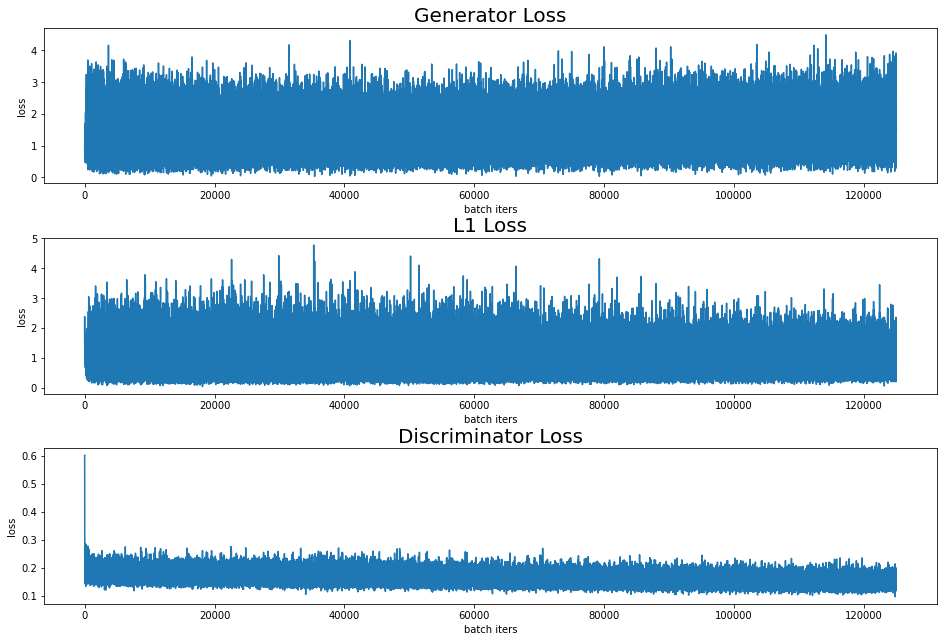

In [22]:
plt.figure(figsize=(16,10))
plt.subplots_adjust(left=0.125, bottom=0.1,  right=0.9, top=0.9, wspace=0.2, hspace=0.35)

plt.subplot(3, 1, 1)
plt.plot(gen_loss_list)
plt.ylabel('loss')  
plt.xlabel('batch iters')  
plt.title('Generator Loss', fontsize=20)

plt.subplot(3, 1, 2) 
plt.plot(dis_loss_list)
plt.ylabel('loss')  
plt.xlabel('batch iters')  
plt.title('L1 Loss', fontsize=20)

plt.subplot(3, 1, 3)
plt.plot(L1_loss_list)
plt.ylabel('loss')  
plt.xlabel('batch iters')  
plt.title('Discriminator Loss', fontsize=20)

plt.show()

<br>

#### 검증 데이터에 대한 생성 이미지 확인하기
***
+ 학습이 완료된 모델에 검증 데이터를 입력하여 생성하는 이미지를 확인 합니다.
***

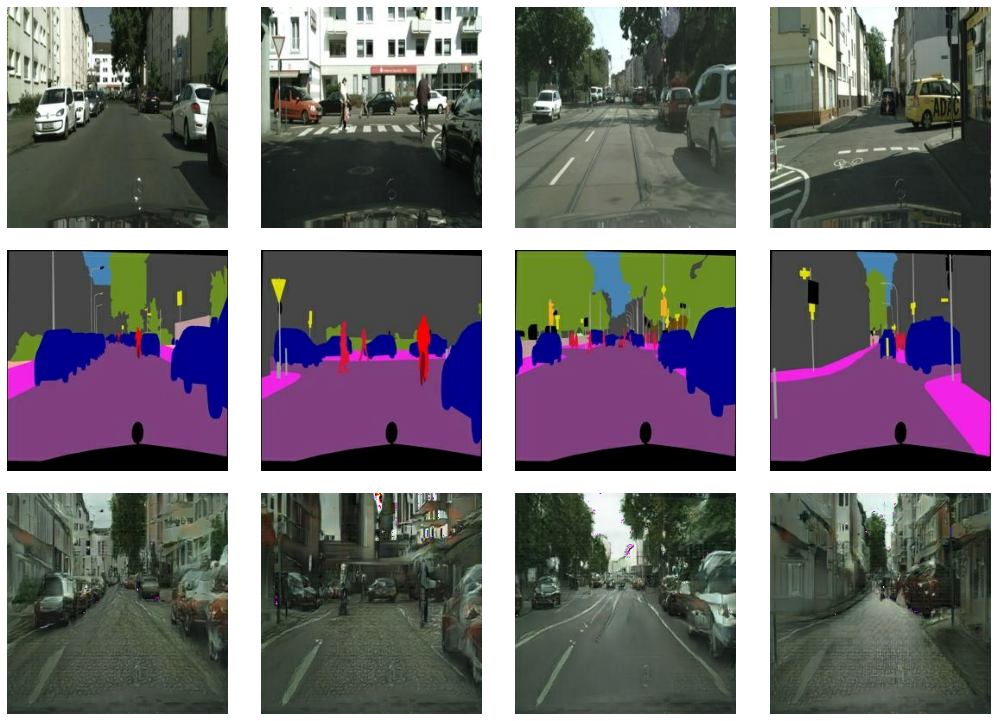

In [21]:
val_path = [val_data_path + path for path in os.listdir(val_data_path)]

seg_images, real_images = [], []
for path in val_path:
    seg_img, real_img = load_img(path)
    seg_images.append(seg_img)
    real_images.append(real_img)

seg_images = np.array(seg_images)

real_images = np.array(real_images)
real_images = (real_images + 1) * 127.5
real_images = real_images.astype(np.uint8)

predict = generator(seg_images)
predict = denormalize(predict)

seg_images = (seg_images + 1) * 127.5
seg_images = seg_images.astype(np.uint8)

plt.figure(figsize=(18, 13))
plt.subplots_adjust(wspace=0.05, hspace=0.1)
for i in range(4):
    plt.subplot(3, 4, i + 1)
    plt.imshow(real_images[i])
    plt.axis("off")
    
    plt.subplot(3, 4, i + 5)
    plt.imshow(seg_images[i])
    plt.axis("off")
    
    plt.subplot(3, 4, i + 9)
    plt.imshow(predict[i])
    plt.axis("off")
    

<br>

#### 학습 과정 gif 시각화
***
+ 학습 과정 중 저장한 이미지를 gif 파일로 시각화 합니다.
***

In [41]:
epoch_nums = [int(path.replace(".png", "")) for path in os.listdir("./dataset/frame/")]
epoch_nums.sort()

img_path_list = [f"./dataset/frame/{epoch}.png" for epoch in epoch_nums]
img_list = [cv2.imread(img_path) for img_path in img_path_list]

imageio.mimsave("./dataset/frame.gif", img_list)

<img src="./img/frame.gif" width=500>

[그림 3] 학습 과정 시각화1

<br><br>

<img src="./img/frame2.gif" width=500>

[그림 4] 학습 과정 시각화2

<br>

## 6. 결론
***
<span style="font-size:12pt; line-height:1.7; font-family:Serif;">
    &nbsp; &nbsp; 도로 이미지를 이용하여 pix2pix 모델을 학습하고 모델이 생성하는 이미지를 확인하는 예제를 진행하였습니다. pix2pix의 특징은  conditional GAN으로, 특정 정보에 따라 생성 이미지를 달리할 수 있다는 것, 생성자 모델의 경우 U-Net을 이용하여 인코딩 단계의 정보를 디코더에 전달한 다는 것, 판별자 모델의 경우 출력의 형태를 행렬로 하여, 생성 이미지의 특정 부분에 대한 진위 여부를 출력한다는 것입니다. 모델을 500회 학습하였으며, 검증 데이터에 대한 모델의 생성 이미지를 확인한 결과 실제 도로와 흡사한 이미지를 생성하였습니다. 특히 차선의 형태를 생성할 수 있었으며, 학습 데이터의 특성에 따라 우측 통행 기준으로 차선을 생성한 것을 확인할 수 있습니다.
</span>

***

#### 참고문헌
***
[1] Olaf Ronneberger, Philipp Fischer, and Thomas Brox. U-Net: Convolutional Networks for Biomedical Image Segmentation, arXiv:1505.04597v1 [cs.CV] (2015), https://arxiv.org/pdf/1505.04597.pdf

***

#### 형상관리 기록
***
+ v1_1: 실습 예제


+ v1_2: 제출 예제 진행


+ v3_1: 학습 과정 gif 제시


+ v4_1: pix2pix, U-Net 설명 추가
***